# Ideas on structure discovering

In [158]:
import random
import networkx as nx
import matplotlib.pyplot as plt

In [159]:
def insert_random(s, n, times):
    l=len(s)
    res = s[:]
    for i in range(0,times):
        pos = random.randint(0,len(res))
        res = res[:pos] + [ n[random.randint(0,len(n)-1)] ] + res[pos:]
    return res

In [160]:
def get_succesor_edges( traces ):
    edges = {}

    for this_trace in traces:
        for idx in range(0, len(this_trace)-1):
            partial_subtrace = this_trace[idx:]
            s0 = partial_subtrace.pop(0)
            try:
                k_plus_1 = partial_subtrace.index(s0)
            except:
                k_plus_1 = len(partial_subtrace)
            # This is the subtrace T, the maximal that not contains s0
            T=partial_subtrace[:k_plus_1]

            # Edges found:
            for si in T:
                e = (s0, si)
                if e in edges.keys():
                    edges[e] = edges[e] + 1
                else:
                    edges[e] = 1
    return edges

In [161]:
def cluster_same_freq(edges, threshold=0):
    weights = list(set(edges.values()))
    sorted(weights)
    groups = {}
    for e in edges.keys():
        w  = edges[e]
        if w in groups.keys():
            groups[w].append( e )
        else:
            groups[w] = [e]
            
    remove_smaller = []
    for w in groups.keys():
        if len( groups[w] ) < threshold:
            remove_smaller.append(w)
    for w in remove_smaller:
        del(groups[w])
        
    return groups
#     print(groups)

In [162]:
def testLeftNode(graph, serials=[]):

    candid=[]
    for serial in serials:
        # Test if Sk can be append at the left
        for Sk in [ Sk for (Sk, Sl) in graph.edges() if Sl == serial[0] ]:

            # Test (Sk, node) exists for all nodes
            if all( [(Sk,node) in graph.edges() for node in serial] ):
                
                # Continue the search to the left
                candid = candid + testLeftNode(graph, [[Sk] + serial] ) 

    return serials + candid

In [163]:
def get_maximal_serials(candidates, verbose=False):
    if len(candidates) <= 1:
        return candidates

    first, c2 = candidates[0], candidates[1:]

    if any( [ len(set(first).intersection(set(n))) == len(set(first)) for n in c2] ):
        if verbose:
            print("%s is already part of another" % first)
        return get_maximal_serials( c2, verbose )
    else:
        return [first] + get_maximal_serials( c2, verbose )
    

In [164]:
# symbols
s = list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789!@#$%^&*()_+=-{}[]\|<>,./?")

## Single Serial Path Discovery

Any trace of the form ```ABCDE``` can be described by a single path without loops in a directed graph. If we define *noise* as any symbol in between the trace different from symbols of the trace we have the following examples:

In [195]:
# Serial Path
serial_path = list("ABCDE")
serial_path

['A', 'B', 'C', 'D', 'E']

In [196]:
noisy_symbols = s[32:60]
# noisy_symbols = s[9:65]
"".join(noisy_symbols)

'ghijklmnopqrstuvwxyz01234567'

In the set below, the goal is to automatically find the serial path ```ABCDE``` and discard the noise.

In [197]:
NUM_INSTANCES=50

In [198]:
# Serial Path with random symbols
traces = []
for i in range(NUM_INSTANCES): # Number of instances
    traces.append ( insert_random(serial_path, noisy_symbols, len(serial_path)*15 ))

for t in traces[:10]:
    print( "".join(t) )

36v1vo1h3kk5Ap6kBpusrwvqC7j0g6opwDnEugvmjh36nlxoruw53ptww06yonp2lr0nnyuqw7zul0wt
1g1ywmkr7msytAnslqyBCzs01qm3xtjupDmrw7v6mwxgihylgprkiozio6m0qzukpt3u1jtmpsEu0o5h
qmuukmkzrirzlq72qnA2ysvvv5yng5y4xspt5uo7p3sg4l2pjmo0gquzp0B4ooot5oxCut5DE62gxmik
01tutrql7nt2rhihw3mgzqjv7zw5hnkz7qnyrq5ljln0A4ir7xyk60B7s0qlgzy6us6CrDksx4rn2En3
qki3ky7n674hoh6zjkzjul2A6k05qsigw0qhr1mhzuz204lum16wu2Blsn26upzokom21l1nCxl6DyEt
3051nr36mAvno5mB321zvC1zn52Du12sx6r7k6l7tp67hio66rh2kE4ihjp716vmzp4h4l6sx2nxow0i
qzg405tixnk52zm5ssltigwq7mqv36A734kB2mjmklCmmy0in1l5youjvru0q76mh1rD3o4qx032Etvl
n3AuwgliB2hwr31yqzghgjo7415gnp5sm4ts5C3s05lDsrjo60huin613p5iuixyoxhhmqi176n6wgEq
szprjnAsghlgq5qg2gowgsm0o3BqrozpmuhkCkw7ux5tmrpvzoDiojtx51sss5nhy1ypqipz34nxEigj
xh164h7A6B7ur5w3nzzCyj6xu1zllDg6znoEj5714plgnv41jz7rs5k5rnopw20tmjuynm27t72uyts2


## Count successors edges of same symbol

Build an adjacency matrix that counts how many edges $(s_0, s_i)$ are in the trace $T=s_0 ... s_i ... s_k$ where $s_i  \neq s_0, \forall 0 < i <= k$

In [199]:
edges1 = get_succesor_edges(traces)

In [200]:
edges_group1 = cluster_same_freq(edges1)

In [201]:
G = {}
for weight in sorted(edges_group1.keys()):
    G[weight] = nx.DiGraph()
    G[weight].add_edges_from( edges_group1[weight] )
        

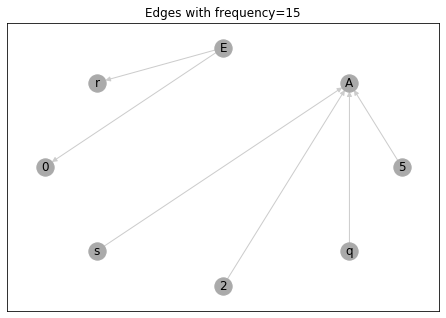

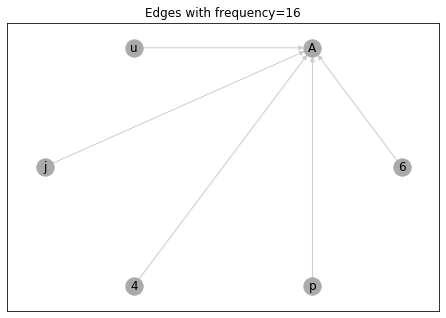

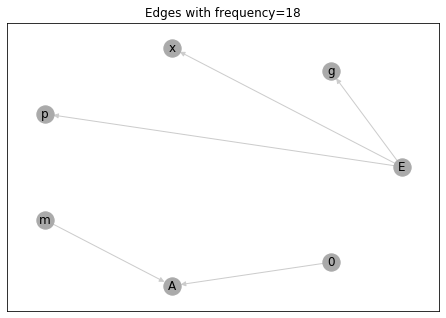

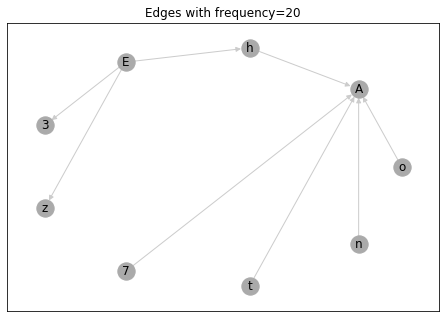

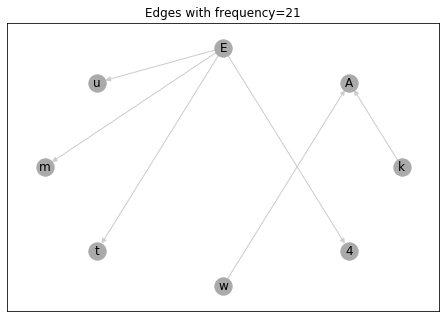

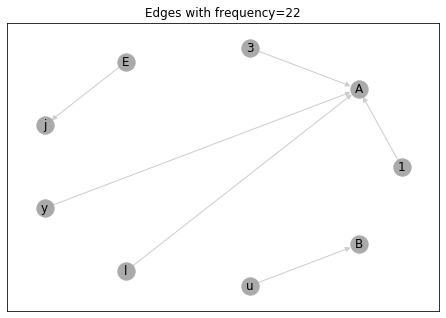

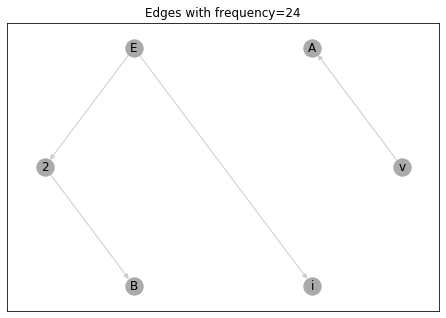

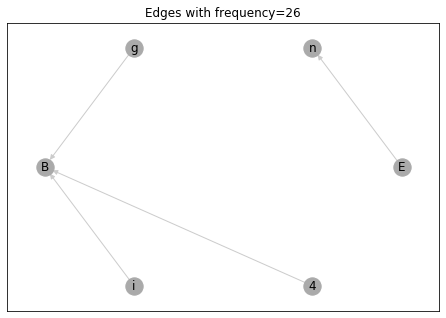

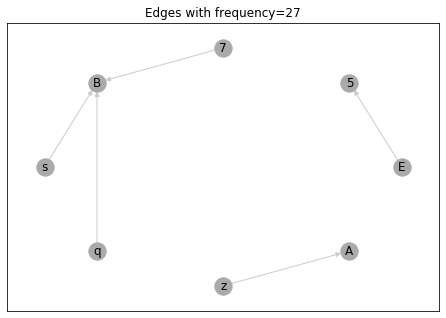

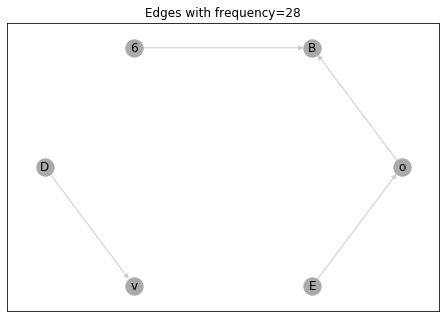

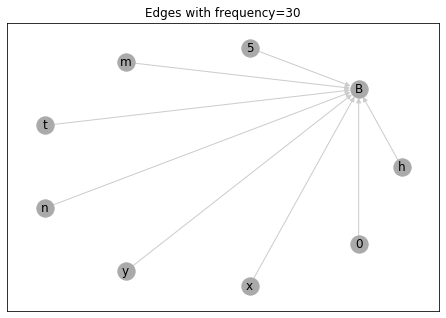

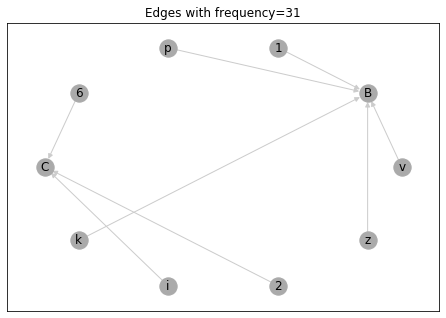

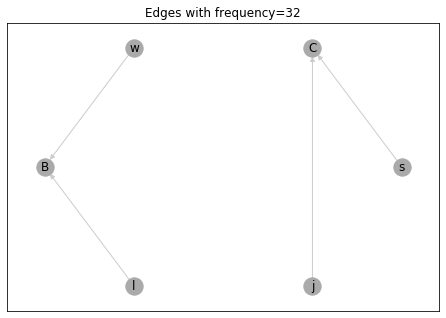

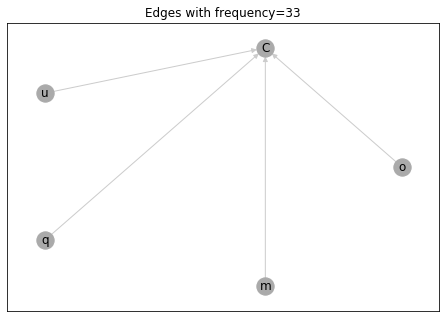

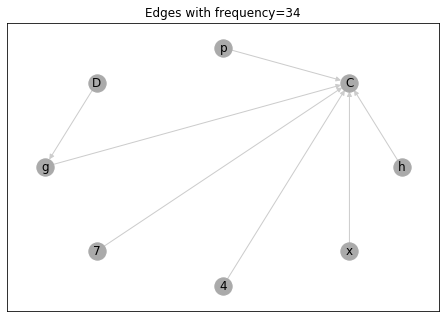

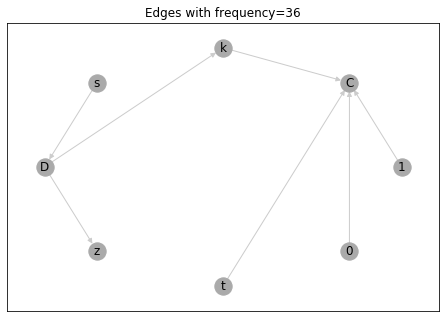

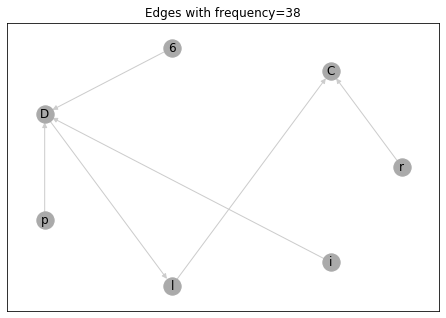

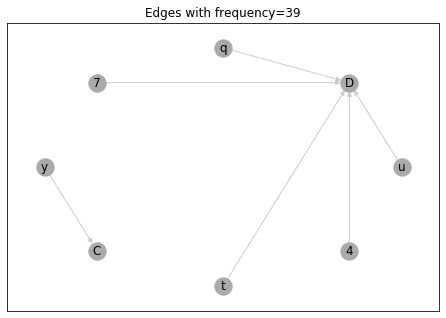

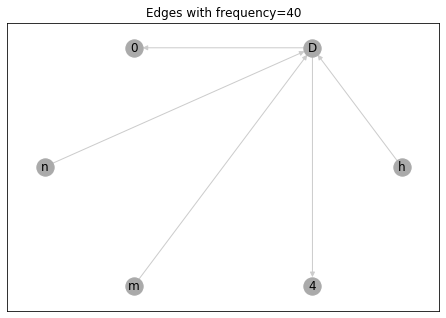

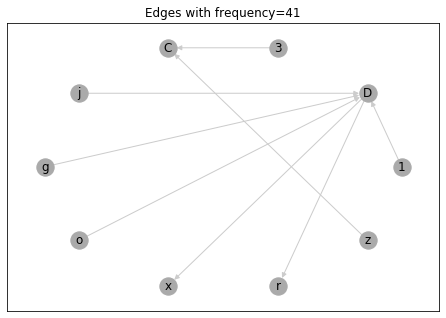

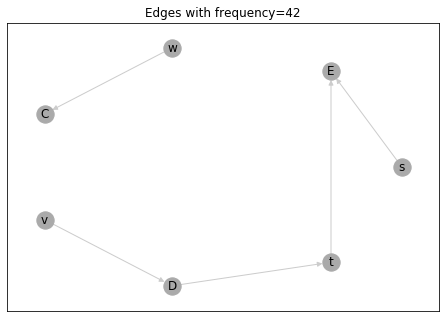

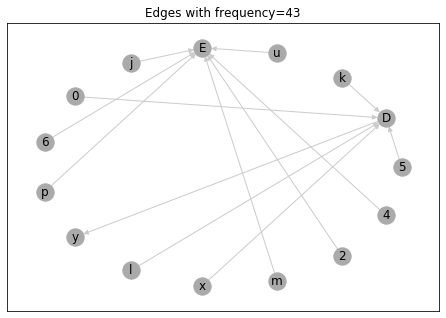

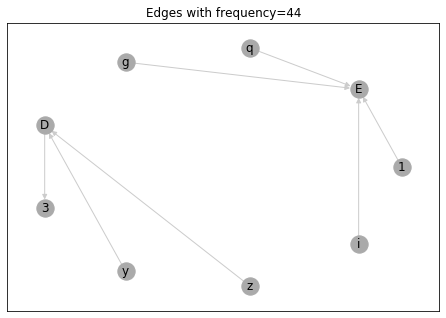

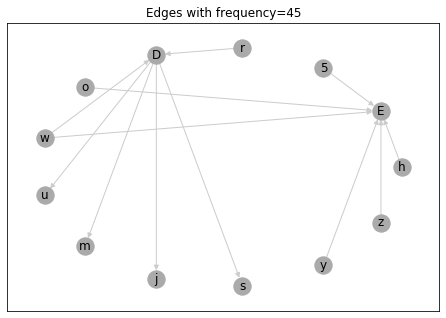

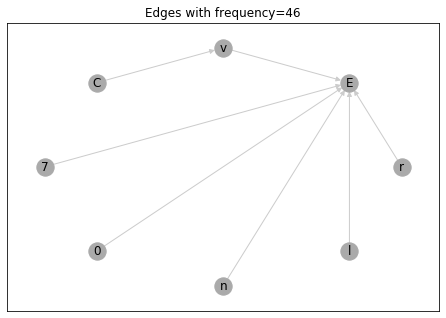

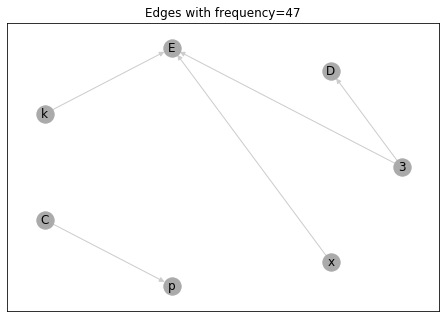

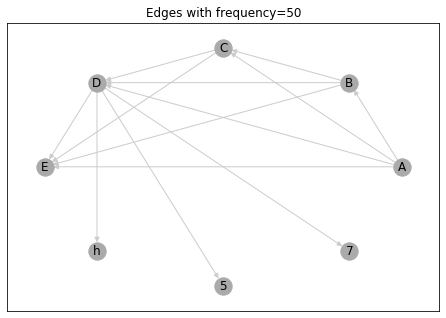

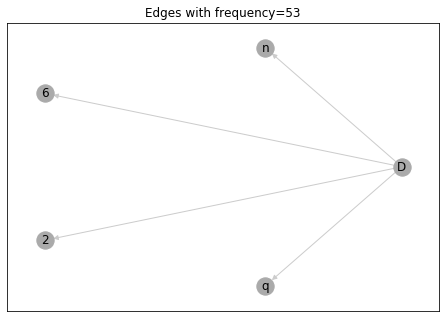

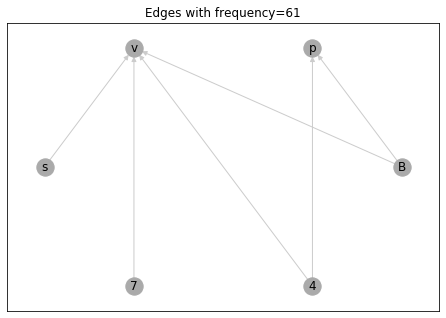

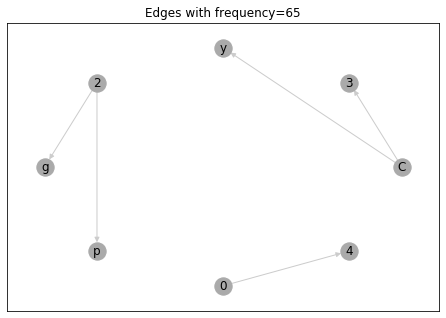

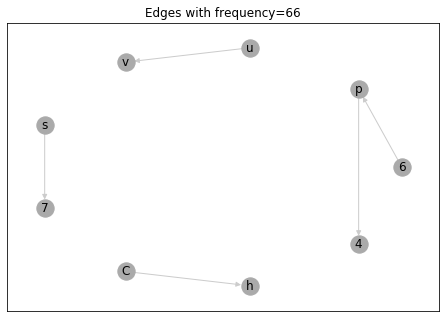

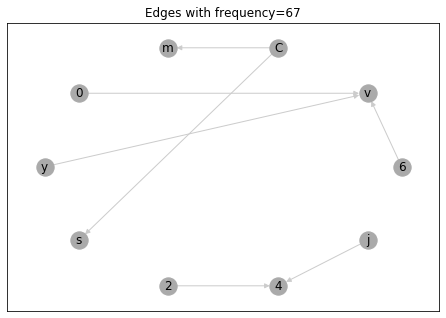

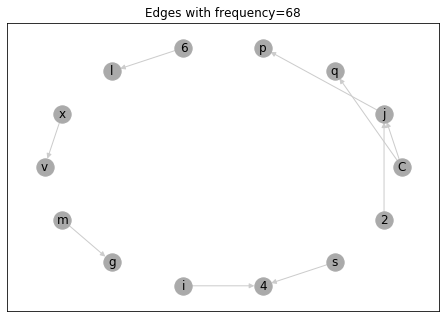

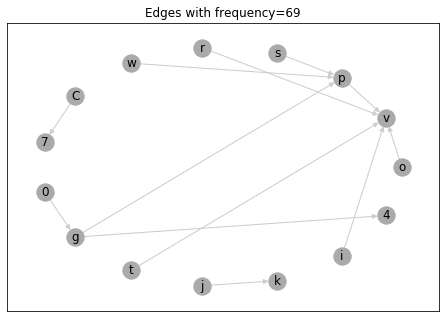

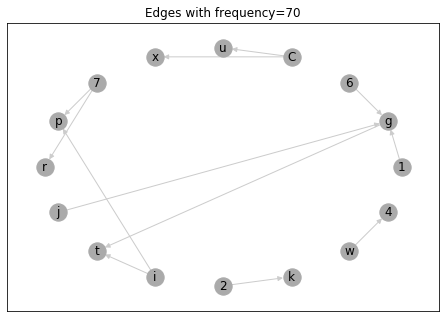

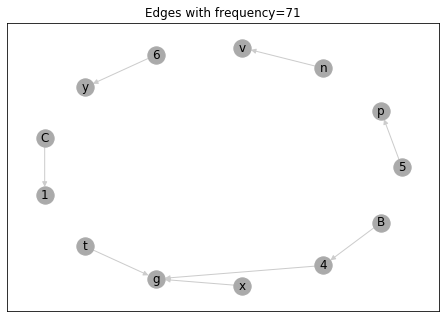

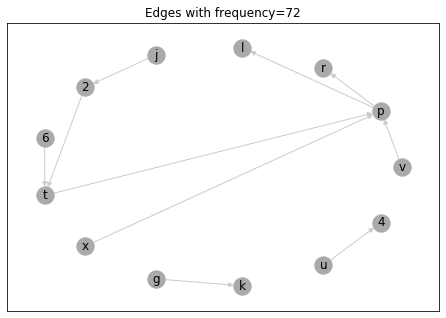

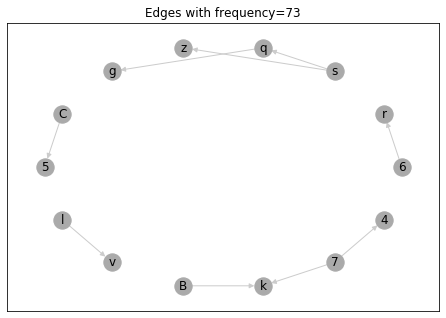

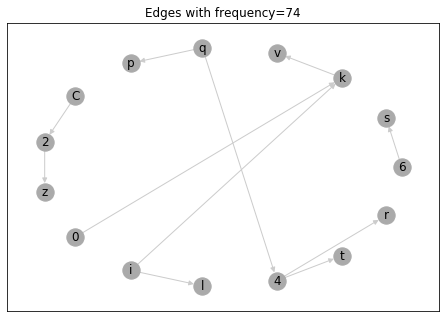

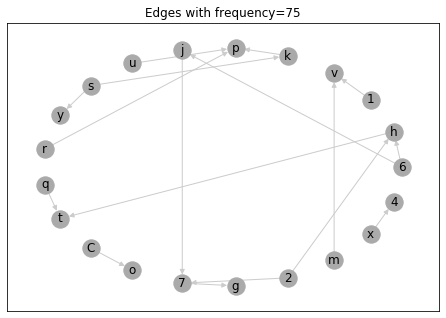

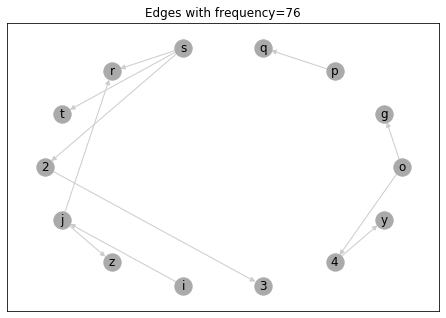

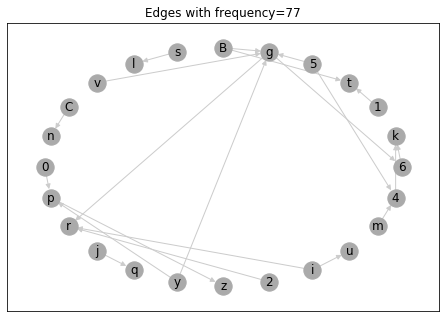

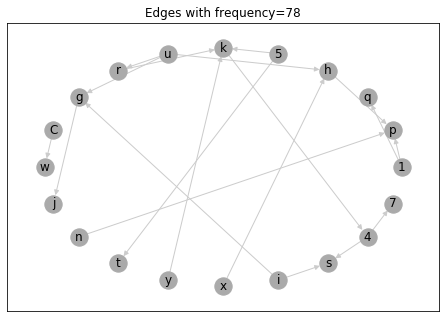

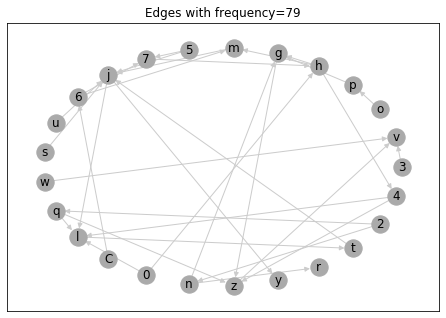

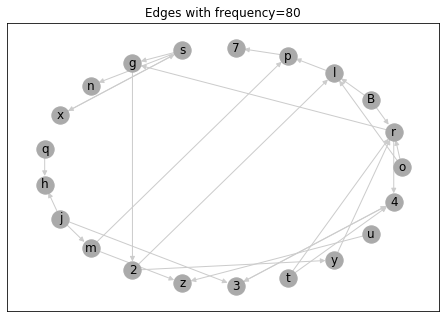

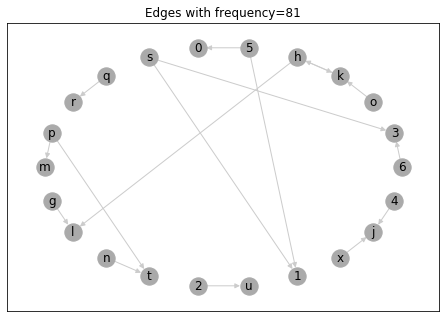

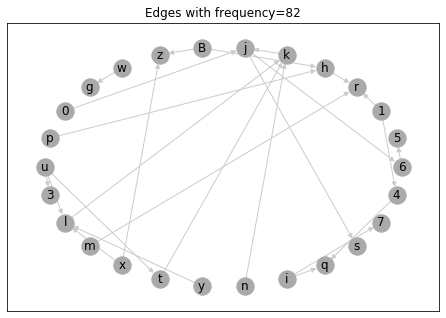

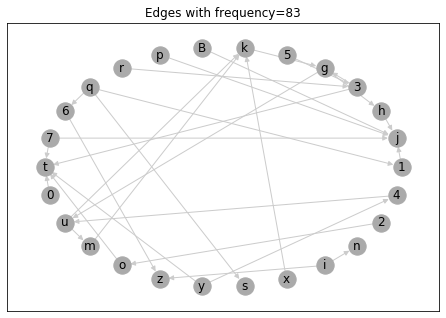

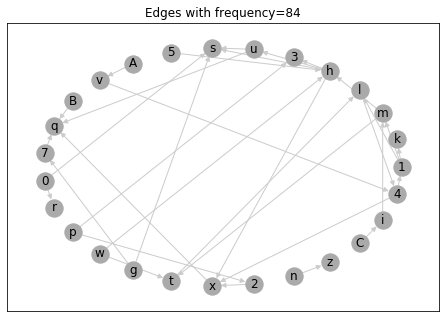

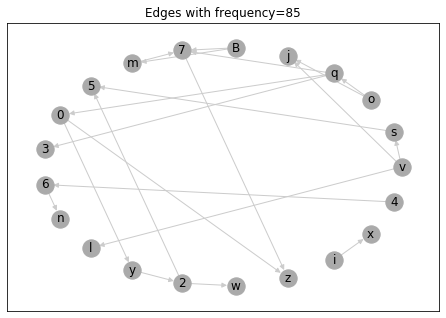

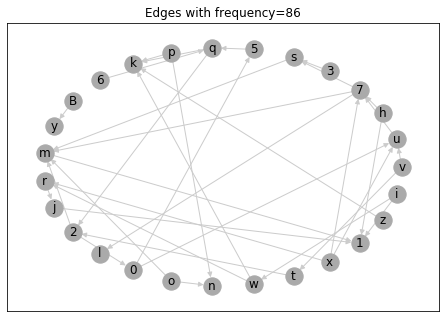

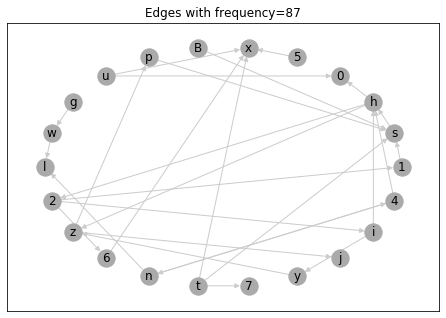

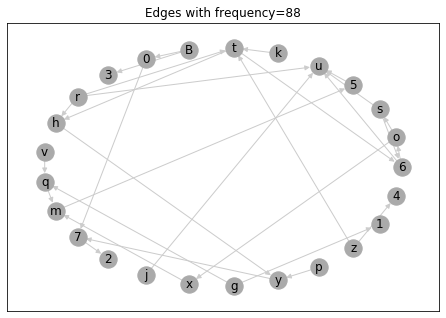

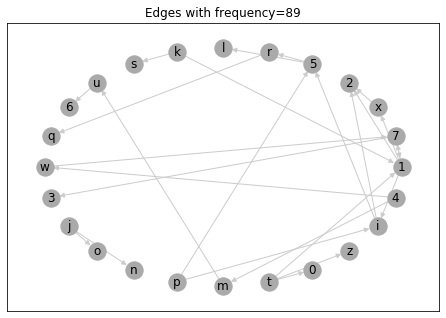

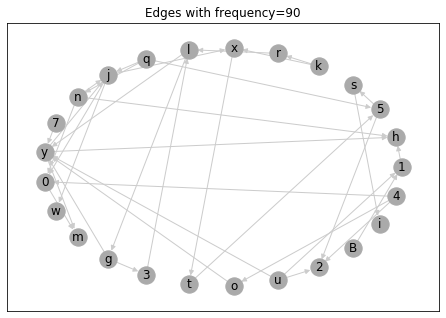

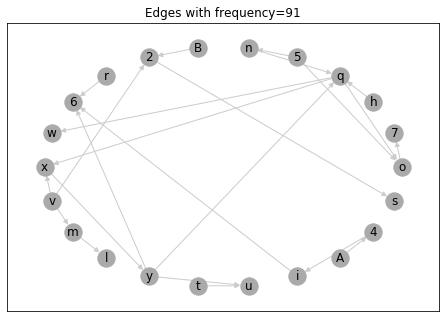

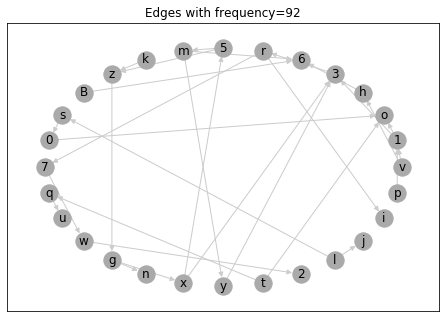

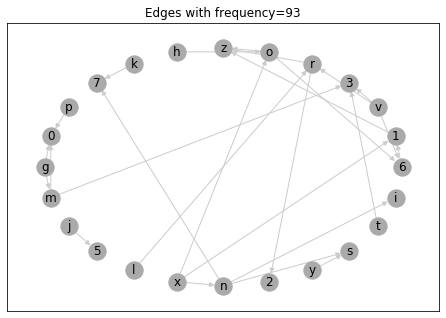

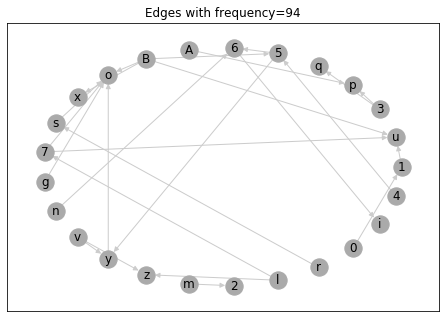

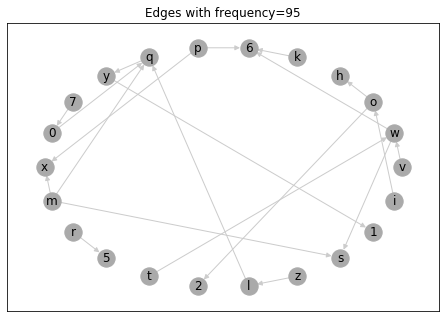

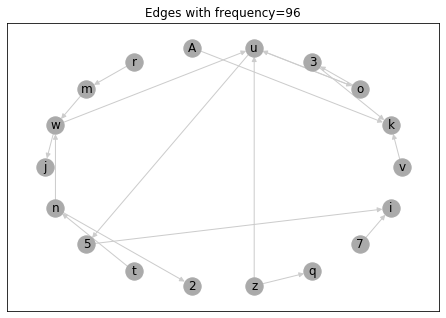

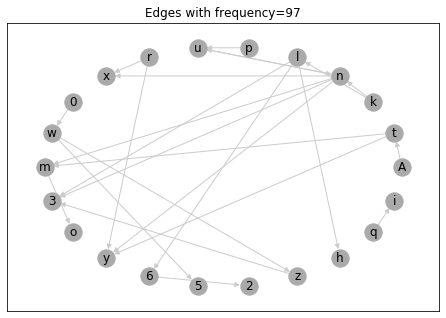

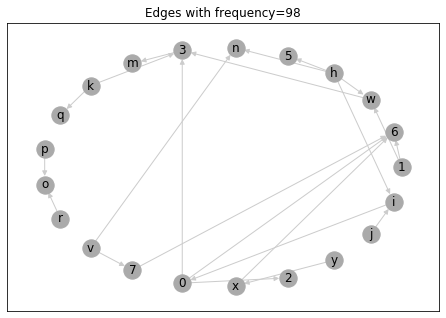

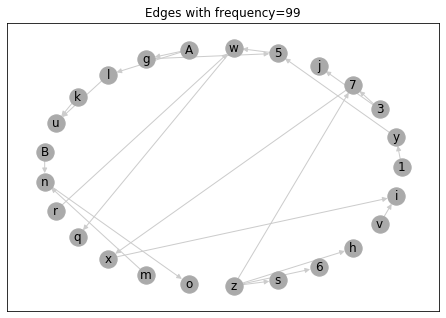

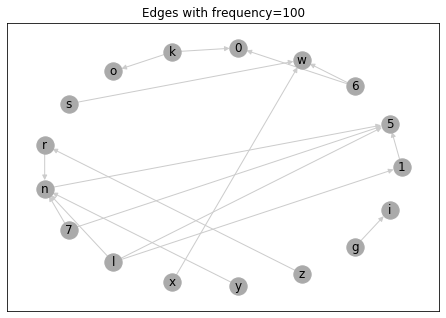

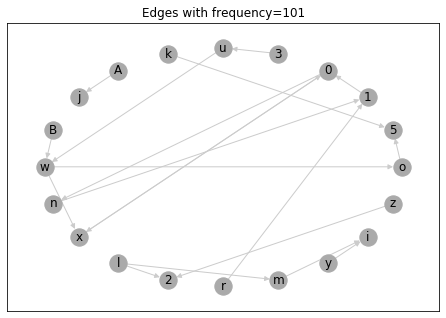

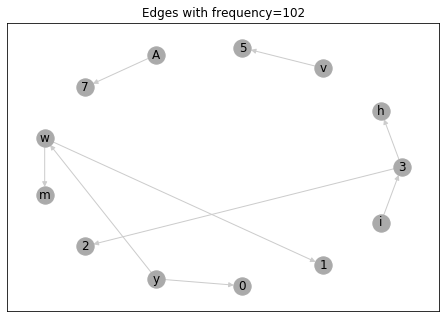

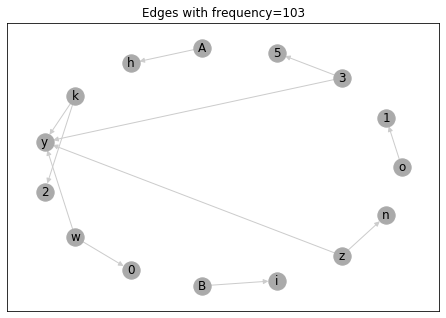

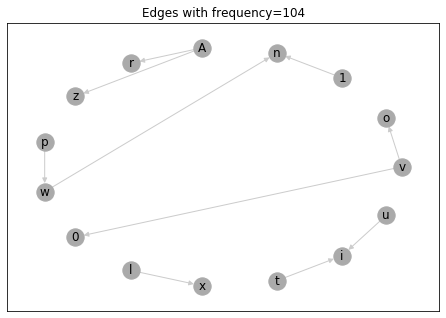

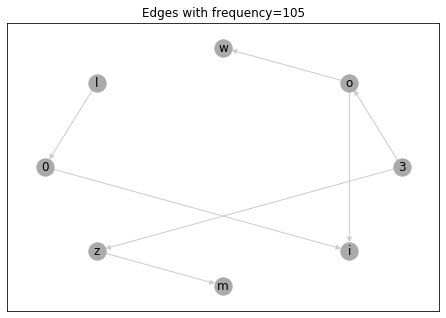

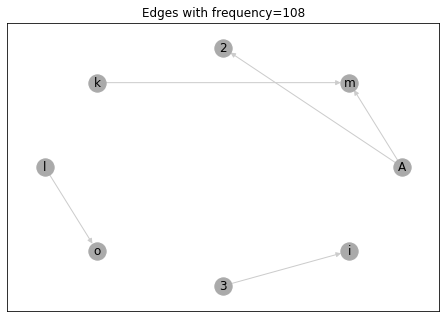

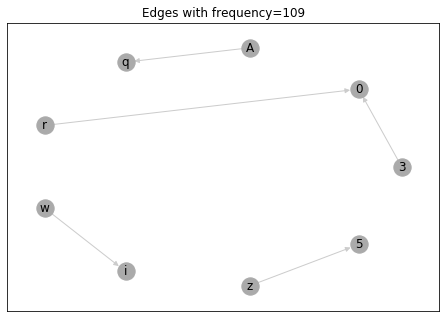

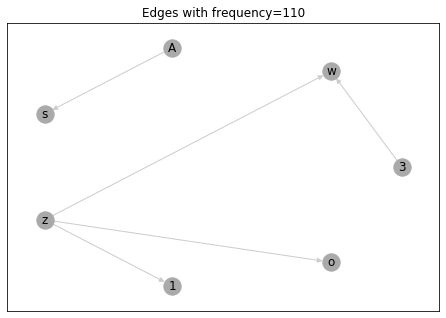

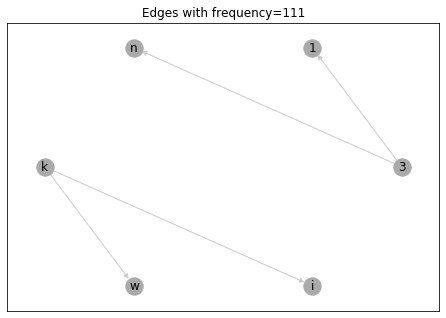

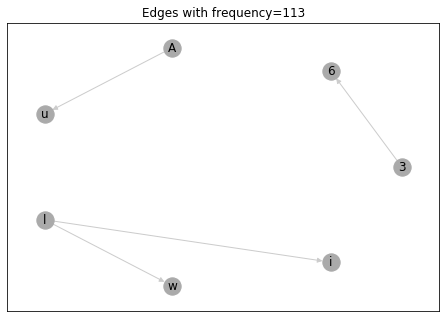

In [202]:
# Graph the candidates

MIN_EDGES_PER_FREQ=4 # min edges per group
MIN_FREQ=len(traces)/4

for weight in G.keys():
    if weight >= MIN_FREQ and len(edges_group1[weight]) >= MIN_EDGES_PER_FREQ:

        nx.draw_circular(G[weight], edge_color="#CCCCCC", node_color="#AAAAAA", with_labels=True)
        #Plot the graph
        plt.axis('on')
        plt.title('Edges with frequency=%d' % weight)
# #     plt.savefig("chess_legends.png") 
        plt.show() 

My claim is that a serial process $S=s_0...s_L$ will be shown as a graph made with the set of edges $(u,v)$ that appears the same amount of times in the set of traces $\Gamma$, and also the adjacency matrix of same frequency edges $M_{freq}$ can be chosen by reordering the nodes such that $\forall 0 < i, j < L$:

* $M_{ii}=0$
* $M_{ij}=1,  i < j $ (1 in upper diagonal)
* $M_{ij}=0,  j < i $ (0 in lower diagonal)

Note 1: that this $S$ is not necessarily unique.

Note 2: $M_{ii}=0$ by construction of the graph, given they have no loops.

In [203]:
nx.to_numpy_matrix(G[NUM_INSTANCES])

matrix([[0., 1., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

But... to check the permutations of $ N $ columns implies to check $N!$ possibilities. Then, a new method different than brute force must be found. 

A simple property (1) is that if a serial path $S$ contains the edges $(s_0, s_1)$, $(s_1, s_2)$, then $(s_0, s_2)$ must exists too. A stronger property (2) is going backward: if $s_{L-p}...s_{L-1}...s_l$ are the last $p$ elements of a serial path of lenght $L$, then a node $s_k$ can be added at the left iff the edges $(s_k, s_{L-q})$ exists for all $0 < q < p$. A third property (3) comes from the observation that any subset of $S$ is also a valid path, then the goal is to search the **maximal** serial path $S$ sharing the same nodes.

Then, let's search in the connection space... backward!

In [204]:
thisG = G[NUM_INSTANCES]
candidates = []
for (u,v) in list(thisG.edges()):
    serial=[u,v]
    candidates = candidates + testLeftNode(thisG, [serial] )[1:]

In [205]:
for c in candidates:
    print(c)

['A', 'B', 'C']
['A', 'B', 'D']
['A', 'B', 'E']
['A', 'C', 'D']
['B', 'C', 'D']
['A', 'B', 'C', 'D']
['A', 'C', 'E']
['B', 'C', 'E']
['A', 'B', 'C', 'E']
['A', 'D', 'E']
['B', 'D', 'E']
['A', 'B', 'D', 'E']
['C', 'D', 'E']
['A', 'C', 'D', 'E']
['B', 'C', 'D', 'E']
['A', 'B', 'C', 'D', 'E']


In [206]:
get_maximal_serials(candidates, verbose=True)

['A', 'B', 'C'] is already part of another
['A', 'B', 'D'] is already part of another
['A', 'B', 'E'] is already part of another
['A', 'C', 'D'] is already part of another
['B', 'C', 'D'] is already part of another
['A', 'B', 'C', 'D'] is already part of another
['A', 'C', 'E'] is already part of another
['B', 'C', 'E'] is already part of another
['A', 'B', 'C', 'E'] is already part of another
['A', 'D', 'E'] is already part of another
['B', 'D', 'E'] is already part of another
['A', 'B', 'D', 'E'] is already part of another
['C', 'D', 'E'] is already part of another
['A', 'C', 'D', 'E'] is already part of another
['B', 'C', 'D', 'E'] is already part of another


[['A', 'B', 'C', 'D', 'E']]

In [207]:
# Now for all Graphs in G
for weight in G.keys():
    thisG = G[weight]
    candidates = []
    for (u,v) in list(thisG.edges()):
        serial=[u,v]
        candidates = candidates + testLeftNode(thisG, [serial] )[1:]
    maximals = []
    for M in get_maximal_serials(candidates):
        if len(M) > 3:
            maximals.append(M)
    if len(maximals) > 0:
        print ("Serial Paths for frequency = %s" % weight)
        print(maximals)

Serial Paths for frequency = 50
[['A', 'B', 'C', 'D', 'E']]


## Conclusions

The algorithm is useful for a len(S) > 3, because the high probability to have the edge set:

$(s_0, s_1), (s_1, s_2), (s_0, s_1)$

In contrast, the chances are dramatically lower to have this set in the same frequency range: 

$(s_0, s_1), (s_1, s_2), (s_2, s_3), (s_0, s_1), (s_0, s_2), (s_0, s_3), (s_1, s_3)$



## Pending tasks

1. Formal writting of the method
1. Test with several interleaved serial processes
1. Test with Observatory logs